## 0. Import Libraries

In [56]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

In [57]:
metadata_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [58]:
image_dirs = [
    Path('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'),
    Path('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')
]

In [59]:
def find_image_path(image_id):
  for dir_path in image_dirs:
    full_path = dir_path / f"{image_id}.jpg"
    if full_path.exists():
      return str(full_path)
  return None

In [60]:
metadata_df['image_path'] = metadata_df['image_id'].apply(find_image_path)
print(metadata_df[['image_id','image_path']].head())

       image_id                                         image_path
0  ISIC_0027419  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1  ISIC_0025030  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2  ISIC_0026769  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3  ISIC_0025661  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4  ISIC_0031633  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [61]:
le_dx = LabelEncoder()
le_sex = LabelEncoder()
le_loc = LabelEncoder()
scaler = StandardScaler()
metadata_df['dx_label'] = le_dx.fit_transform(metadata_df['dx'])
metadata_df['age_norm'] = scaler.fit_transform(metadata_df[['age']].fillna(metadata_df['age'].mean()))
metadata_df['sex_encoded'] = le_sex.fit_transform(metadata_df['sex'])
metadata_df['loc_encoded'] = le_loc.fit_transform(metadata_df['localization'])
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,dx_label,age_norm,sex_encoded,loc_encoded
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2,1.662953,1,11
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2,1.662953,1,11
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2,1.662953,1,11
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2,1.662953,1,11
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2,1.367434,1,4


In [62]:
train_df, test_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df['dx_label'], random_state=42)

In [63]:
image_size =224     # expected by ResNet 224x224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       # ImageNet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [64]:
class SkinLesionDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    row = self.dataframe.iloc[idx]

    # Load image
    img_path = row['image_path']
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    # Load metadata
    age = row['age_norm']
    sex = row['sex_encoded']
    loc = row['loc_encoded']

    metadata = torch.tensor([age, sex, loc], dtype=torch.float)

    # Label
    label = torch.tensor(row['dx_label'], dtype=torch.long)

    return image, metadata, label

In [65]:
train_dataset = SkinLesionDataset(train_df, transform=train_transform)
test_dataset = SkinLesionDataset(test_df, transform=test_transform)

In [66]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [67]:
# Check out what's inside train_loader
train_features_batch, train_metadata_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_metadata_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3]), torch.Size([32]))

In [68]:
# Define unnormalize transform
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return img_tensor * std[None, None, :] + mean[None, None, :]

Image size: torch.Size([224, 224, 3])
Label: 5, Label size: torch.Size([])
Metadata: tensor([-0.4057,  1.0000,  9.0000]), Metadata size: torch.Size([3])


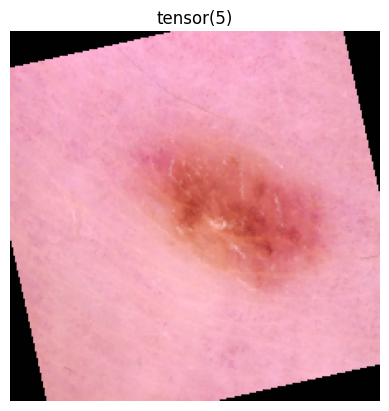

In [69]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label, metadata = train_features_batch[random_idx], train_labels_batch[random_idx], train_metadata_batch[random_idx]
img = img.permute(1,2,0)
img = unnormalize(img)  # undo normalization
img = torch.clamp(img, 0, 1)
plt.imshow(img.squeeze())
plt.title(label)
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, Label size: {label.shape}")
print(f"Metadata: {metadata}, Metadata size: {metadata.shape}")

In [70]:
class SkinCancerClassifier(nn.Module):
  def __init__(self, num_metadata_features, num_classes):
    super().__init__()

    # Image feature  extraction (ResNet without final layer)
    self.cnn_backbone = models.resnet50(pretrained=True)
    image_feat_dim = self.cnn_backbone.fc.in_features
    self.cnn_backbone.fc = nn.Identity()   # remove final classifier

    # Metadata processor
    self.meta_net = nn.Sequential(
        nn.Linear(in_features=num_metadata_features, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU()
    )

    # Combined classifier
    self.classifier = nn.Sequential(
        nn.Linear(in_features = image_feat_dim + 32, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features=256, out_features=num_classes)
    )

  def forward(self, image, metadata):
    image_features = self.cnn_backbone(image)
    metadata_features = self.meta_net(metadata)
    combined = torch.cat((image_features, metadata_features), dim=1)
    output = self.classifier(combined)
    return output

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [72]:
num_metadata_features = 3
num_classes = 7

model = SkinCancerClassifier(num_metadata_features = num_metadata_features,
                             num_classes = num_classes).to(device)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SkinCancerClassifier(
  (cnn_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequ

In [73]:
next(model.parameters()).device

device(type='cuda', index=0)

In [74]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-4)

In [75]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)

# Set the number of epochs
epochs = 10

# For early stopping
best_f1 = 0
patience = 3
trigger_times = 0

# Create training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  ### Training
  train_loss, train_acc = 0, 0
  all_preds_train = []
  all_labels_train = []
  model.train()
  # Loop through the training batches
  for batch, (X, metadata, y) in enumerate(train_loader):
    X, metadata, y = X.to(device), metadata.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X, metadata)
    # Convert logits to prediction labels
    y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    # Store predictions and true labels
    all_preds_train.extend(y_pred_labels.cpu().numpy())
    all_labels_train.extend(y.cpu().numpy())
    # 2. Calculate the loss/accuracy
    loss = criterion(y_pred, y)
    train_loss+=loss
    train_acc+=accuracy_fn(y, y_pred_labels)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Print what's happening
    if batch % 100 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

  # Divide the total train loss by length of train loader
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  # Calculate train f1 score
  train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

  ### Testing
  test_loss, test_acc = 0, 0
  all_preds_test = []
  all_labels_test = []
  model.eval()
  with torch.inference_mode():
    for (X, metadata, y) in test_loader:
      X, metadata, y = X.to(device), metadata.to(device), y.to(device)
      # 1. Forward pass
      test_pred = model(X, metadata)
      # Convert logits to prediction labels
      test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      # Store predictions and true labels
      all_preds_test.extend(test_pred_labels.cpu().numpy())
      all_labels_test.extend(y.cpu().numpy())
      # 2. Calculate the loss/ accuracy
      loss = criterion(test_pred, y)
      test_loss+=loss
      test_acc+=accuracy_fn(y, test_pred_labels)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    # Calcuate test f1 score
    test_f1 = f1_score(all_labels_test, all_preds_test, average='macro')

  # Print what's happening
  print(f"\n Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f}% | Train F1 score: {train_f1:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.3f}% | Test F1 score: {test_f1:.3f}")

  # Check for early stopping
  if test_f1 > best_f1:
    best_f1 = test_f1
    trigger_times = 0
    # Save the best model
    torch.save(model.state_dict(), "best_model.pth")
  else:
    trigger_times += 1
    print(f"Early stopping counter: {trigger_times}/{patience}")
    if trigger_times >= patience:
      print("Early stopping triggered!")
      break

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/8012 samples
Looked at 3200/8012 samples
Looked at 6400/8012 samples

 Train Loss: 0.73705 | Train Accuracy: 73.933% | Train F1 score: 0.380 | Test Loss: 0.65014 | Test Accuracy: 74.102% | Test F1 score: 0.467
Epoch: 1
---------
Looked at 0/8012 samples
Looked at 3200/8012 samples
Looked at 6400/8012 samples

 Train Loss: 0.54514 | Train Accuracy: 80.690% | Train F1 score: 0.554 | Test Loss: 0.52494 | Test Accuracy: 81.527% | Test F1 score: 0.534
Epoch: 2
---------
Looked at 0/8012 samples
Looked at 3200/8012 samples
Looked at 6400/8012 samples

 Train Loss: 0.45798 | Train Accuracy: 83.811% | Train F1 score: 0.678 | Test Loss: 0.44782 | Test Accuracy: 83.991% | Test F1 score: 0.699
Epoch: 3
---------
Looked at 0/8012 samples
Looked at 3200/8012 samples
Looked at 6400/8012 samples

 Train Loss: 0.37690 | Train Accuracy: 86.674% | Train F1 score: 0.744 | Test Loss: 0.39840 | Test Accuracy: 86.124% | Test F1 score: 0.728
Epoch: 4
---------
Looked at 0/8012 

In [ ]:
class_names = [
    "Melanocytic nevi (nv)",
    "Melanoma (mel)",
    "Benign keratosis-like lesions (bkl)",
    "Basal cell carcinoma (bcc)",
    "Actinic keratoses (akiec)",
    "Vascular lesions (vasc)",
    "Dermatofibroma (df)"
]

In [ ]:
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

In [ ]:
cm = confusion_matrix(all_labels_test, all_preds_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# To see the mapping:
for i, class_name in enumerate(le_dx.classes_):
    print(f"{i}: {class_name}")